In [1]:
using Revise, UnboundedBNN, Plots, Random, Optimisers, ProgressMeter, Zygote, LinearAlgebra

In [2]:
function generate_samples(N, ω; seed=42, T=Float32)
    t = rand(MersenneTwister(seed), T, N)
    u = sqrt.(t)
    y = rand(MersenneTwister(seed), (-1, 1), N)
    x = zeros(N, 2)
    for n in 1:N
        tmp = randn(MersenneTwister(seed+n), T, 2)
        x[n, 1] = y[n] * u[n] * cos(ω * u[n] * pi / 2) + convert(T, 0.02) * tmp[1]
        x[n, 2] = y[n] * u[n] * sin(ω * u[n] * pi / 2) + convert(T, 0.02) * tmp[2]
    end
    return x, y
end


generate_samples (generic function with 1 method)

In [1]:
N = 1024
ω = 5
x_train, y_train = generate_samples(N, ω)
x_test,  y_test  = generate_samples(N, ω; seed=123456);

UndefVarError: UndefVarError: `generate_samples` not defined

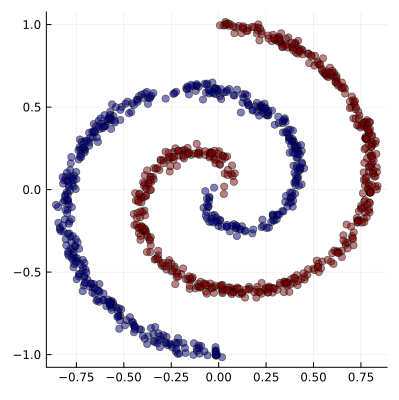

In [4]:
plot(x_train[:,1], x_train[:,2], seriestype=:scatter, zcolor=y_train, legend=false, color=:jet; alpha=0.5, size=(400, 400))

In [5]:
function loss(y, x, model; batch_prop = 1.0)
    
    post_support = UnboundedBNN.support(model.posterior)
    post_pdf = UnboundedBNN.pdf.(Ref(model.posterior), post_support)

    # calculate expected log likelihood
    # loglikelihoods = map(zip(x,y)) do (xi, yi)
    loglikelihoods = map(1:size(x,1)) do n
        output = model(x[n,:], zeros(length(x[n,:])))
        logln = map(output) do out
            return y[n] == 1 ? first(out)[1] : first(out)[2]
        end
        # out_samples = vcat(first.(out)...)
        # println(out)
        # logln = yi == 1 ? out_samples) : out_samples[2]
        return dot(logln, post_pdf)
    end
    expected_logl = sum(loglikelihoods)

    return -expected_logl
end

loss (generic function with 1 method)

In [6]:
dimin = 2
dimmid = 32
dimout = 2

max_layers = 20

expansion_layer = Linear(dimin => dimmid)
intermediate_layer = ntuple(_ -> Chain(Linear(dimmid => dimmid), ReLU()), max_layers)
output_layer = ntuple(_ -> Chain(Linear(dimmid => dimout), Softmax(dimout)), max_layers)
prior = Poisson(0.5)
posterior = SafeTruncatedPoisson([UnboundedBNN.invsoftplus(1f0)])
model = Unbounded(expansion_layer, intermediate_layer, output_layer, prior, posterior)

opt = Optimisers.setup(Adam(), model)
Optimisers.adjust!(opt, 0.005f0)
Optimisers.adjust!(opt.posterior, 0.0005f0)

In [13]:
epochs = 1000
batch_size = 32
loss_train = zeros(epochs)
loss_test  = zeros(epochs)
gs = nothing
@showprogress for e in 1:epochs
    for n in Iterators.partition(randperm(N), batch_size)
        _, gs = Zygote.withgradient(m -> loss(y_train[n], x_train[n,:], m; batch_prop = length(n)/N), model)
        opt, model = Optimisers.update!(opt, model, gs[1])
    end
    loss_train[e] = loss(y_train, x_train, model)
    loss_test[e] = loss(y_test, x_test, model)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:11:07


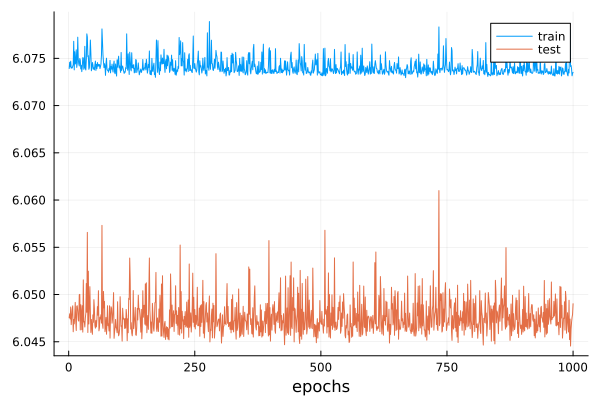

In [14]:
plot(log.(loss_train), label="train")
plot!(log.(loss_test), label="test")
xlabel!("epochs")

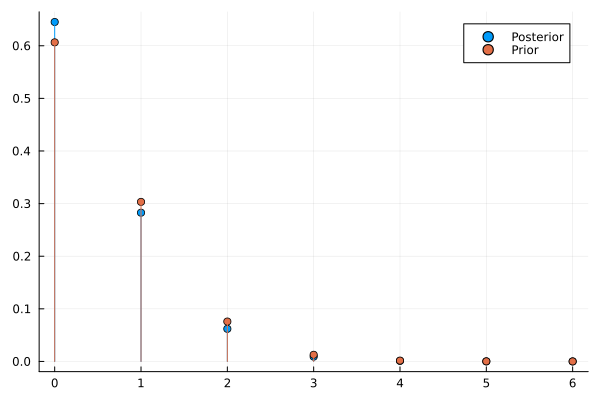

In [15]:
plot(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.posterior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Posterior")
plot!(UnboundedBNN.support(model.posterior), UnboundedBNN.pdf.(Ref(model.prior), UnboundedBNN.support(model.posterior)), line=:stem, marker=:circle, label="Prior")

In [16]:
model(x_test[1,:], zeros(2))

(([-0.3210466846746969, -1.2924011324701608], nothing), ([-0.32111075390898103, -1.2922319120567902], nothing), ([-0.32210220363704595, -1.2896183048184753], nothing), ([-0.32075411281453003, -1.2931743787866035], nothing), ([-0.3241992668778334, -1.2841210119990005], nothing), ([-0.3222635200916911, -1.28919394095864], nothing), ([-0.31937298836114636, -1.296835754759972], nothing))

Accuracy: 0.796875


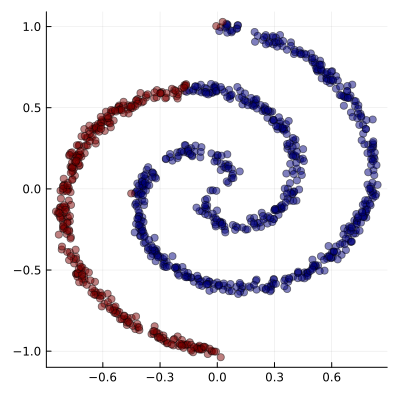

In [17]:

post_support = UnboundedBNN.support(model.posterior)
post_pdf = UnboundedBNN.pdf.(Ref(model.posterior), post_support)

predictions = map(1:N) do n
    output = model(x_test[n,:], zeros(2))
    output_logln = first.(output)
    expected_logln = mapreduce(ni -> output_logln[ni] .* post_pdf[ni], +, 1:length(output_logln))
    return argmax(expected_logln) - 1
end
println("Accuracy: ", sum((predictions .* -2 .+ 1) .== y_test) / N)
plot(x_test[:,1], x_test[:,2], seriestype=:scatter, zcolor=predictions, legend=false, color=:jet; alpha=0.5, size=(400, 400))